# Load and display downloaded point cloud

In [ ]:
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import glob
import matplotlib.pyplot as plt
import numpy as np
from os import path
import os

In [ ]:
root_path = os.getenv('WIN_GITHUB')

In [ ]:
%pwd

'/mnt/c/Users/GGPC/Documents/GitHub/wind-simulation/nbs'

In [ ]:
print(root_path)

/mnt/c/Users/GGPC/Documents/GitHub/


In [ ]:
c_path_north = os.path.join(*[root_path,'wind-simulation/data/raw/','lds-auckland-north-lidar-1m-dem-2016-2018-GTiff'])
c_path_south = os.path.join(*[root_path,'wind-simulation/data/raw/','lds-auckland-south-lidar-1m-dsm-2016-2017-GTiff'])
#ds-auckland-south-lidar-1m-dsm-2016-2017-GTiff

In [ ]:
print(c_path_north)

/mnt/c/Users/GGPC/Documents/GitHub/wind-simulation/data/raw/lds-auckland-north-lidar-1m-dem-2016-2018-GTiff


In [ ]:
raster_files = glob.glob(f"{c_path_north}/*.tif") + glob.glob(f"{c_path_south}/*.tif")

In [ ]:
rasters = []

In [ ]:
# Open the rasters
for file in raster_files:
    src = rasterio.open(file)
    rasters.append(src)

In [ ]:
# Merge rasters
mosaic, out_trans = merge(rasters)

In [ ]:
mosaic[0,20,20]

-9999.0

/tmp/ipykernel_3518/1990142664.py:10: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("BrBG").copy()
  cmap.set_bad(color='white')


<matplotlib.image.AxesImage>

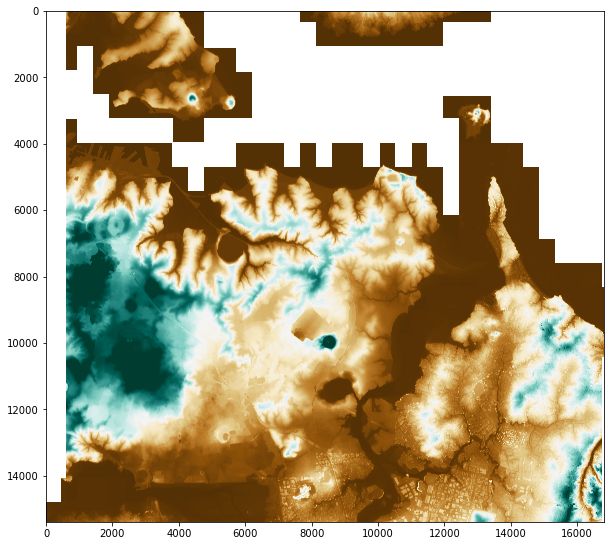

In [ ]:
 #Set the no-data value (replace with the actual no-data value for your data)
no_data_value = -9999

# Mask the no-data values
mosaic_masked = np.ma.masked_where(mosaic[0] == no_data_value, mosaic[0])

# Choose a colormap
cmap = plt.cm.BrBG
# Set the 'bad' data (masked data) color to 'white' or any other color
cmap.set_bad(color='white')

# Plot the masked array with the colormap
plt.figure(figsize=(10, 10))
plt.imshow(mosaic_masked, cmap=cmap)

# Optionally, set the color range to the 2nd and 98th percentiles to enhance contrast
vmin, vmax = np.percentile(mosaic_masked.compressed(), (2, 98))
plt.imshow(mosaic_masked, cmap=cmap, vmin=vmin, vmax=vmax)

In [ ]:
max_height = mosaic_masked.data.max()

In [ ]:
data_surface = mosaic_masked.data[0:8000,0:-1]

In [ ]:
data_surface[data_surface <0 ] = 0

<matplotlib.image.AxesImage>

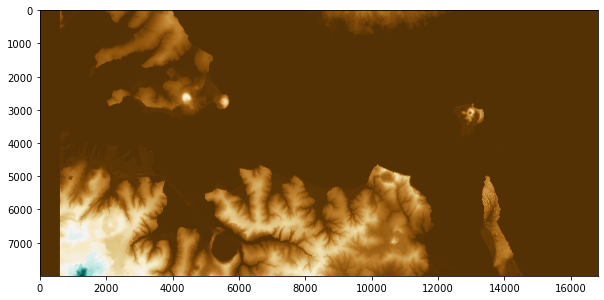

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(data_surface,cmap=cmap)

In [ ]:
delta_x, delta_y = 10, 10

In [ ]:
stride = 5

In [ ]:
# Pad the 'data_surface' array to the right with 2000 columns of zeros
extended_data_surface = np.pad(data_surface, ((0, 0), (0, 2000)), 'constant', constant_values=0)[::stride,::stride]
print(extended_data_surface)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


<matplotlib.image.AxesImage>

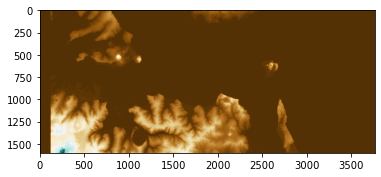

In [ ]:
plt.imshow(extended_data_surface,cmap=cmap)

In [ ]:
matrix_size = (extended_data_surface.shape[0]*extended_data_surface.shape[1]*200/1e6)*8

In [ ]:
print(f'Matrix Size {matrix_size} MB')

Matrix Size 9630.72 MB


In [ ]:
z_max = int(np.round(max_height,-2)); print(z_max)

200


In [ ]:
def height_matrix_to_voxel_matrix(height_matrix, headroom, stride):
    # Get the dimensions of the 2D height matrix
    
    strided_matrix = height_matrix[::stride,::stride]
    rows, cols = strided_matrix.shape
    
    # Determine the maximum height to set the depth of the 3D voxel matrix
    max_height = int(np.max(height_matrix)) + int(headroom)
    print(max_height)
    
    # Create a 3D voxel matrix initialized to 0 (no voxel)
    # The shape is (height, rows, cols) to represent (z, y, x) coordinates
    voxel_matrix = np.zeros((max_height, rows, cols), dtype=np.int8)
    
    # Fill the voxel matrix based on the heights specified in the height_matrix
    for x in range(rows):
        for y in range(cols):
            height = int(strided_matrix[x, y]/stride)
            voxel_matrix[:height, x, y] = 1  # Fill column with voxels up to the specified height
    return voxel_matrix

In [ ]:
voxel_matrix = height_matrix_to_voxel_matrix(extended_data_surface,0,stride)

170


<matplotlib.image.AxesImage>

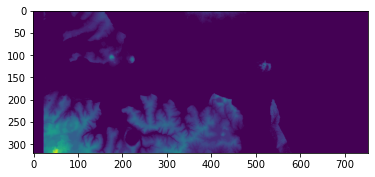

In [ ]:
plt.imshow(np.sum(voxel_matrix,0))

In [ ]:
from vedo import *
settings.default_backend='vtk'

In [ ]:
voxel_matrix_ = voxel_matrix.astype(np.uint8)

In [ ]:
 volume = Volume(voxel_matrix_)

In [ ]:
 plotter = Plotter()

In [ ]:
plotter.add(volume)

<vedo.plotter.Plotter>

In [ ]:
show(volume)

# Determine boundary conditions

### Boundary Labels:
- The boundaries of the simulation box are denoted as follows:
  - **N**: North
  - **S**: South
  - **E**: East
  - **W**: West
  - **T**: Top
  - **B**: Bottom

### Voxel Space Orientation:
- **z-axis**: Represents the first dimension of the voxel space.
- **y-axis**: Represents the second dimension, with the 0th position being north.
- **x-axis**: Represents the third dimension, with the 0th position being to the west.

### Wind Direction and Boundary Conditions:
The simulation accounts for wind blowing horizontally at specific compass bearings, leading to 8 distinct cases for setting boundary conditions:

- **Cases 0 to 3** (Cardinal Directions): Wind at 0° (N), 90° (E), 180° (S), 270° (W). One boundary in either the xz or yz plane will have a specified velocity, either positive or negative, corresponding to the wind direction.

- **Cases 4 to 7** (Inter-Cardinal Directions):
  - **NE quadrant**: Positive y-velocity (vy), Negative x-velocity (vx)
  - **SE quadrant**: Negative y-velocity (vy), Negative x-velocity (vx)
  - **SW quadrant**: Negative y-velocity (vy), Positive x-velocity (vx)
  - **NW quadrant**: Positive y-velocity (vy), Positive x-velocity (vx)

### Cross Section and Land Boundaries:
- The landscape is represented within the voxel space, dividing the box's cross-section into areas of land and clear air.
- The interaction between the wind and the landscape introduces variations in boundary conditions across different parts of the box.

### Question on Boundary Conditions:
1. **Non-slip Conditions for Land Voxels**: Can all land voxels be treated as non-slip conditions to simulate the interaction with the wind accurately?

### Proposed Boundary Condition Implementation:
- **Wind Incident Borders**: For borders facing the direction of the incoming wind, apply constant velocity boundaries to simulate the wind entering the simulation space.
- **Do Nothing for the Ceiling**: The top boundary (ceiling) of the simulation box does not directly influence the wind simulation and may be treated as a 'do nothing' condition.
- **Remaining Borders and Air Spaces**: For parts of the box not defined as land or directly affected by the incoming wind, apply 'Do Not Care' or appropriate boundary conditions to simulate the natural behavior of air flow around and over the landscape.

In [ ]:
def determine_inlet_outlet(wind_direction):
    """
    Determine the inlet and outlet sides of the box based on wind direction.
    
    Parameters:
    - wind_direction: int or float representing the compass bearing of the wind.
    
    Returns:
    - Tuple of (inlet, outlet) where each is a string representing the sides of the box.
    """
    if wind_direction == 0:
        return ('N', 'S')
    elif wind_direction == 90:
        return ('E', 'W')
    elif wind_direction == 180:
        return ('S', 'N')
    elif wind_direction == 270:
        return ('W', 'E')
    elif 0 < wind_direction < 90:
        return ('NE', 'SW')
    elif 90 < wind_direction < 180:
        return ('SE', 'NW')
    elif 180 < wind_direction < 270:
        return ('SW', 'NE')
    elif 270 < wind_direction < 360:
        return ('NW', 'SE')
    else:
        raise ValueError("Invalid wind direction. Should be between 0 and 360 degrees.")


In [ ]:
test_directions = [0, 90, 180, 270, 45, 135, 225, 315]

for direction in test_directions:
    inlet, outlet = determine_inlet_outlet(direction)
    print(f"Wind Direction: {direction} degrees -> Inlet: {inlet}, Outlet: {outlet}")

In [ ]:
def determine_axis(wind_direction):
    """
    Determine the axis affected by the wind direction for cardinal directions.
    
    Parameters:
    - wind_direction: The wind direction in degrees (0, 90, 180, 270).
    
    Returns:
    - int: 0 for the x-axis, 1 for the y-axis.
    """
    if wind_direction in [0, 180]:
        return 0  # Wind affects the x-axis
    elif wind_direction in [90, 270]:
        return 1  # Wind affects the y-axis
    else:
        raise ValueError("Invalid wind direction. Expected one of: 0, 90, 180, 270.")

# Testing the function
test_directions = [0, 90, 180, 270]

for direction in test_directions:
    print(f"Wind direction: {direction} degrees -> Axis affected: {determine_axis(direction)}")


In [ ]:
import numpy as np

def calculate_velocity_components(wind_direction, wind_velocity):
    """
    Calculate the velocity components for wind coming from any angle.
    
    Parameters:
    - wind_direction: The wind direction in degrees from the North (0 degrees).
    - wind_velocity: The magnitude of the wind velocity.
    
    Returns:
    - A tuple (vx, vy) representing the velocity components in the x (East) and y (North) directions.
    """
    # Convert wind direction from degrees to radians
    wind_direction_radians = np.radians(wind_direction)
    
    # Calculate velocity components
    # Note: Wind direction is measured from the North, so adjustments are made accordingly
    vx = wind_velocity * np.sin(wind_direction_radians)  # Eastward component
    vy = wind_velocity * np.cos(wind_direction_radians)  # Northward component
    
    return (vx, vy)

# Testing the function with different wind directions
test_directions = [0, 45, 90, 135, 180, 225, 270, 315]
wind_velocity = 10  # Example wind velocity magnitude

for direction in test_directions:
    vx, vy = calculate_velocity_components(direction, wind_velocity)
    print(f"Wind direction: {direction} degrees -> Velocity components: vx={vx:.2f}, vy={vy:.2f}")


In [ ]:
import numpy as np

def set_wind_boundary_conditions(land_voxel_mesh, wind_direction, wind_velocity, gridInfo, precisionPolicy):
    """
    Set boundary conditions for simulation with wind over land.
    
    Parameters:
    - land_voxel_mesh: 3D numpy array representing land as True (land) and False (air).
    - wind_direction: Compass bearing of the wind (0, 90, 180, 270, or quadrant).
    - wind_velocity: Magnitude of the wind velocity.
    - gridInfo: Information about the simulation grid.
    - precisionPolicy: Policy determining the numerical precision of computations.
    """
    print("Setting boundary conditions based on wind direction and land presence...")
    
    # Initialize boundary conditions list
    BCs = []

    # Determine inlet and outlet based on wind_direction
    inlet, outlet = determine_inlet_outlet(wind_direction)
    
    # Set non-slip boundary conditions for land voxels
    land_indices = np.argwhere(land_voxel_mesh)
    BCs.append(BounceBackHalfway(tuple(land_indices.T), gridInfo, precisionPolicy))
    
    # Set inlet boundary condition with wind velocity
    vel_inlet = np.zeros((len(inlet), 3), dtype=precisionPolicy.compute_dtype)
    if wind_direction in [0, 90, 180, 270]:  # Cardinal directions
        vel_inlet[:, determine_axis(wind_direction)] = wind_velocity
    else:  # Quadrant directions
        vel_inlet[:, 0], vel_inlet[:, 1] = calculate_quadrant_velocity(wind_direction, wind_velocity)
    BCs.append(EquilibriumBC(tuple(inlet.T), gridInfo, precisionPolicy, np.ones(len(inlet)), vel_inlet))
    
    # Apply do nothing condition for the ceiling and other non-land boundaries
    # Additional logic to identify and apply these conditions based on `land_voxel_mesh` and `wind_direction`
    
    return BCs
